# **Istanbul Water Crisis Detection Project**
--------

## **A. Introduction**

#### **A.1. Description & Disscusion of the Background**

Istanbul formerly Byzantium and Constantinople, is the largest city in Turkey and the country's economic, cultural and historic center. The city straddles the Bosporus strait, and lies in both Europe and Asia, with a population of over 15 million residents. Istanbul is the largest city in Europe, and the world's fifteenth-largest city. [For Detailed Information](https://en.wikipedia.org/wiki/Istanbul)

However, the water problem has always been a problem for Istanbul since the middle ages. Since the Byzantine period, the city's rapid growth has consumed its water resources, and the city's rulers built water channels to carry the surrounding waters to the city.[For Detailed Information](https://www.middleeasteye.net/news/turkey-drought-Dams-low-water-level-rain-agriculture)

In 2020, decreasing rainfall and global warming brought the city's water stocks back to 21.66%. In this study, I will first create the fresh water resources of the city according to the information on the official website and check their coordinates with the Foursquare Api. [For Detailed Information](https://data.ibb.gov.tr/en/)

Then, I will calculate the water balance required for the city not to have water crisis, and the day when the city will be drought, with the multilayer perceptron, which is a neural network.

#### **A.2. Data Description**

To consider the problem we can list the datas as belows

* I will get the clean water resources information of the city from the official website of Istanbul, [Official Website](https://www.iski.istanbul)
* However, only the names and occupancy rates of water resources can be seen on this site. Therefore, I will manually determine the coordinates of the relevant water resources on "Google Maps" and check them with foursquare.
* I used **Forsquare API** to check if the coordinates of the Dams are correct.
* I received meteorological data such as the city's water consumption and rainfall from the open data portal of the metropolitan municipality. [Istanbul Municipality Open Data Portal](https://data.ibb.gov.tr/en)


## **B. Methodology**
----

#### **B.1. Creating data table and data pre-processing**

You can access database by entering my Github account. According to Official Numbers, There Are 10 "Dam-Lake-River" that Provide Clean Water to Istanbul.

In [504]:
import pandas as pd 
import numpy as np
import requests

url = 'https://raw.githubusercontent.com/Trmerlin/Istanbul-Water-Crisis-Detection-Project/main/IstanbulsDams.cvs'
df = pd.read_csv(url)

print(str(len(df)) + ' Fresh Water Sources Found in the Database.')

10 Fresh Water Sources Found in the Database.


**Make sure we get the correct data.**

In [505]:
df.head()

,Dam,TotalCapacity,Latitude,Longitude
0,Omerli Dam,48.555,40.976815,29.342496
1,Pabucdere River,3.790,41.638278,28.064477
2,Sazlidere Dam,4.777,41.126020,28.689251
3,Buyukcekmece Dam,25.951,41.038046,28.574248
4,Alibeykoy Dam,10.441,41.119147,28.921652


#### **B.2. Controlling Dam Coordinates with Foursquare API**

We need to import some external libraries for mapping of the datas and we will work on Forsquare API.

In [506]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported. ✓')

Libraries imported. ✓


#### We Will Use Folium Library To Visualize Geographic Details Of Istanbul`s Dams.

In [507]:
from geopy.geocoders import Nominatim # cOnvert an address into latitude and longitude values
import folium # Map Rendering Library
print('Libraries imported. ✓')

Libraries imported. ✓


#### Lets, Use Geopy Library To Get The Latitude And Longitude Values Of Istanbul.

In [508]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="ist_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of `{}` are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of `Istanbul, TR` are 41.0096334, 28.9651646.


#### Time to Integrate Foursquare API!

In [509]:
CLIENT_ID = 'NWLSU1BAXKABB3OQS53RNNVPEMFKQKG4LYLTSWMASLRWAV5W' #It Will Be Destroyed When The Project Is Over.
CLIENT_SECRET = 'OQ14UEUECXLGHV2OMLH02NRXKXQGB0OL0PI3VOGZJRHSVTLX' #It Will Be Destroyed When The Project Is Over.
VERSION = '20180605' # Foursquare API version

In [510]:
istanbul_data = df

Dam_latitude = istanbul_data.loc[0, 'Latitude'] # latitude value
Dam_longitude = istanbul_data.loc[0, 'Longitude'] # longitude value

Dam_name = istanbul_data.loc[0, 'Dam'] # neighborhood name

print('Latitude and longitude values of `{}` is {}, {}.'.format(Dam_name, 
                                                               Dam_latitude, 
                                                               Dam_longitude))

Latitude and longitude values of `Omerli Dam` is 40.976814668624, 29.3424955365078.


In [511]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [512]:
LIMIT = 100
radius = 1200
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=NWLSU1BAXKABB3OQS53RNNVPEMFKQKG4LYLTSWMASLRWAV5W&client_secret=OQ14UEUECXLGHV2OMLH02NRXKXQGB0OL0PI3VOGZJRHSVTLX&v=20180605&ll=40.976814668624,29.3424955365078&radius=1200&limit=100'

In [513]:
results = requests.get(url).json()

In [514]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Ömerli Barajı,Lake,40.977048,29.340912
1,Nakkaş Parkı,Theme Park,40.977943,29.340830
2,Limon Kafe,Café,40.974670,29.343833
3,Ciftlik Evi,Café,40.973640,29.344139
4,Masal Köy Kılıç’ın Bahçesi,Turkish Restaurant,40.985008,29.345318


In [515]:
print('{} venues were returned by Foursquare. ✓ '.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare. ✓ 


#### **B.3. Discovering Structures Around the Dam Coordinates**

Let's create a function to get all Dam-Lake in Istanbul

In [516]:
def getNearbyVenues(names, latitudes, longitudes, radius=1200, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Dam', 
                  'Dam Latitude', 
                  'Dam Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now we can run the above function on each Dam and create a new dataframe called **around_dams**

In [517]:
around_dams = getNearbyVenues(names=istanbul_data['Dam'],
                                   latitudes=istanbul_data['Latitude'],
                                   longitudes=istanbul_data['Longitude']
                                  )

Omerli Dam
Pabucdere River
Sazlidere Dam
Buyukcekmece Dam
Alibeykoy Dam
Terkos Lake
Kazandere
Elmali Dam
Darlik Dam
Istranca Lakes


#### Let's check the size of the resulting dataframe

In [518]:
print(around_dams.shape)
around_dams.head()

(72, 7)


,Dam,Dam Latitude,Dam Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Omerli Dam,40.976815,29.342496,Ömerli Barajı,40.977048,29.340912,Lake
1,Omerli Dam,40.976815,29.342496,Nakkaş Parkı,40.977943,29.340830,Theme Park
2,Omerli Dam,40.976815,29.342496,Limon Kafe,40.974670,29.343833,Café
3,Omerli Dam,40.976815,29.342496,Ciftlik Evi,40.973640,29.344139,Café
4,Omerli Dam,40.976815,29.342496,Masal Köy Kılıç’ın Bahçesi,40.985008,29.345318,Turkish Restaurant


#### Let's check how many venues were returned for each Dam and sort them in count

In [519]:
summary = around_dams.groupby('Dam').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Dam Latitude', 'Dam Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,Dam,Count
0,Buyukcekmece Dam,2
1,Istranca Lakes,3
2,Kazandere,3
3,Sazlidere Dam,3
4,Alibeykoy Dam,4


#### Let's Ask the Unique Categories.

In [520]:
print('There are `{}` uniques categories.'.format(len(around_dams['Venue Category'].unique())))

There are `41` uniques categories.


#### **B.3. Analyzing Each Dam**

We will anayze each Dam with venues informations

In [521]:
# one hot encoding
istanbul_onehot = pd.get_dummies(around_dams[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
istanbul_onehot['Dam'] = around_dams['Dam'] 

# move neighborhood column to the first column
list_column = istanbul_onehot.columns.tolist()
number_column = int(list_column.index('Dam'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
istanbul_onehot = istanbul_onehot[list_column]

istanbul_onehot.head()

,Dam,Arepa Restaurant,Athletics & Sports,Bakery,Beach,Beer Garden,Bike Shop,Botanical Garden,Breakfast Spot,Brewery,Burrito Place,Café,Campground,Comfort Food Restaurant,Convenience Store,Department Store,Dessert Shop,Dog Run,Farm,Food Truck,Forest,Garden,Grocery Store,Hotel,Lake,Lighthouse,Meyhane,Mountain,Nature Preserve,Paintball Field,Pie Shop,Plaza,Pub,Restaurant,River,Scenic Lookout,Seafood Restaurant,Steakhouse,Tea Room,Theme Park,Turkish Restaurant,Whisky Bar
0,Omerli Dam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Omerli Dam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Omerli Dam,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Omerli Dam,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Omerli Dam,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Next, let's group rows by Dam and by taking the mean of the frequency of occurrence of each category

In [522]:
istanbul_grouped = istanbul_onehot.groupby('Dam').mean().reset_index()
istanbul_grouped.head()

,Dam,Arepa Restaurant,Athletics & Sports,Bakery,Beach,Beer Garden,Bike Shop,Botanical Garden,Breakfast Spot,Brewery,Burrito Place,Café,Campground,Comfort Food Restaurant,Convenience Store,Department Store,Dessert Shop,Dog Run,Farm,Food Truck,Forest,Garden,Grocery Store,Hotel,Lake,Lighthouse,Meyhane,Mountain,Nature Preserve,Paintball Field,Pie Shop,Plaza,Pub,Restaurant,River,Scenic Lookout,Seafood Restaurant,Steakhouse,Tea Room,Theme Park,Turkish Restaurant,Whisky Bar
0,Alibeykoy Dam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.000000,0.0,0.000000,0.250000,0.000000,0.0,0.0,0.000000,0.250000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000
1,Buyukcekmece Dam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.000000,0.000000
2,Darlik Dam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.166667,0.000000,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.166667
3,Elmali Dam,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.055556,0.0,0.166667,0.0,0.000000,0.111111,0.000000,0.055556,0.0,0.055556,0.111111,0.055556,0.0,0.055556,0.000000,0.055556,0.0,0.0,0.000000,0.055556,0.0,0.055556,0.000000,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.000000,0.000000
4,Istranca Lakes,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


#### Let's Put That Into a Pandas Dataframe.

First, let's write a function to sort the venues in descending order.


In [523]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each dam.

In [524]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Dam']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Dams_venues_sorted = pd.DataFrame(columns=columns)
Dams_venues_sorted['Dam'] = istanbul_grouped['Dam']

for ind in np.arange(istanbul_grouped.shape[0]):
    Dams_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

Dams_venues_sorted.head(10)

,Dam,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Alibeykoy Dam,Forest,Paintball Field,Tea Room,Lake,Dog Run
1,Buyukcekmece Dam,Steakhouse,Lake,Whisky Bar,Burrito Place,Dog Run
2,Darlik Dam,Whisky Bar,Turkish Restaurant,Dessert Shop,Lake,Pub
3,Elmali Dam,Campground,Forest,Department Store,Garden,Plaza
4,Istranca Lakes,Lake,Convenience Store,Campground,Whisky Bar,Café
5,Kazandere,Lake,Botanical Garden,Forest,Whisky Bar,Campground
6,Omerli Dam,Café,Farm,Theme Park,Turkish Restaurant,Lake
7,Pabucdere River,Brewery,Beach,River,Mountain,Café
8,Sazlidere Dam,Lake,Scenic Lookout,Plaza,Whisky Bar,Burrito Place
9,Terkos Lake,Lake,Café,Turkish Restaurant,Forest,Comfort Food Restaurant


### *Mission Successfully Completed! We Detected Lake or River Record within 1.2 Km of the Coordinates We Received from the Database. Now is the time to integrate our fresh water resources on a map according to their size.*

#### We Can Create A Map Of Istanbul With Dams Superimposed On Top. We use latitude and longitude values to get the visual. Also, Visualize The Water Resources By Creating Circles According To Their Total Volume.

In [525]:
map_istanbul = folium.Map(location=[latitude, longitude], tiles="Stamen Terrain", zoom_start=9.4)

print(len(istanbul_data))
# add markers to map
for lat, lng, Dam in zip(df['Latitude'], df['Longitude'], df['Dam']):
    label = '{}'.format(Dam)
    label = folium.Popup(label, parse_html=True)
    
for i in range(0,len(istanbul_data)):
        folium.CircleMarker(
        location=[istanbul_data.iloc[i]['Latitude'], istanbul_data.iloc[i]['Longitude']],
        radius=istanbul_data.iloc[i]['TotalCapacity']*0.6,
        popup=istanbul_data.iloc[i]['Dam'],
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_istanbul)  
    
map_istanbul

10


#### **B.4. Istanbul's Water Crisis Prediction**

After determining the location of our dams, it was time to estimate the thirst.

For this, I will use the data provided by the Istanbul municipality.
These are basically "Dam Occupancy Rates Of The Last 6 Years For December.21.202X", "Total Annual Rain", "Annual Amount of Water Pumped from Surrounding Provinces" and Finally, "Annual Consumption". I will calculate the balance of the water coming out.

Then I will try to establish a proportion between the "Net Water Balance" in the City and the 1-year change percentages of the dams.

*Small Reminders*

* **TotalChangeOneYear** = [Percent Of This Year] - [Percent Of Last Year]  *Istanbul Municipality gives occupancy rates for the same day.*
* **PumpWater** = *The total water provided to the city by the 2 pump systems established by the Municipality to meet the water requirement*
* **TotalAmountofWaterGivenDuringtheYear** = Total amount of water provided for all services(individual, corporate) throughout the year according to official figures
* **TotalInput** = [PumpWater] + [TotalAnnualRain]  *Total amount of fresh water coming to the city by pumps and precipitation, official records.*

* **Net** = [TotalInput] - [TotalAmountofWaterGivenDuringtheYear]

*All water values have been found by dividing 10 million cubic meters. Data standardization has thus been achieved.*

In [540]:
import matplotlib.pyplot as plt #For Graphics

url = 'https://raw.githubusercontent.com/Trmerlin/Istanbul-Water-Crisis-Detection-Project/main/FullnesRatioOfDams.cvs'
df = pd.read_csv(url)

df.head(7)

,Year,Percentage,TotalAnnualRain,TotalChangeOneYear,TotalAmountofWaterGivenDuringtheYear,PumpWater,TotalInput,Net
0,21.12.2014,53.88,82.63,15.80,92.44,47.04,129.67,37.23
1,21.12.2015,60.24,87.24,6.36,96.51,18.58,105.82,9.31
2,21.12.2016,38.85,77.81,-21.39,99.86,31.09,108.90,9.04
3,21.12.2017,58.17,92.23,19.32,102.96,33.96,125.19,22.23
4,21.12.2018,77.29,95.74,19.12,104.09,37.97,133.71,29.62
5,21.12.2019,33.97,55.87,-43.32,106.17,31.19,87.06,-19.11
6,21.12.2020,21.70,52.09,-12.27,102.90,47.77,100.56,-2.34


First of all, by visualizing the primary data we have, try to find the best algorithm we should use.

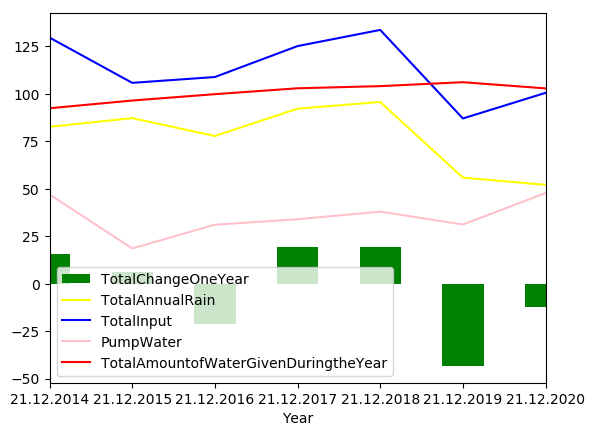

In [542]:
ax = plt.gca()

df.plot(kind='bar',x='Year',y='TotalChangeOneYear',color='green', ax=ax)
df.plot(kind='line',x='Year',y='TotalAnnualRain', color='yellow', ax=ax)
df.plot(kind='line',x='Year',y='TotalInput', color='blue', ax=ax)
df.plot(kind='line',x='Year',y='PumpWater', color='pink', ax=ax)
df.plot(kind='line',x='Year',y='TotalAmountofWaterGivenDuringtheYear', color='red', ax=ax)

#### Let's simplify our data frame.

In [545]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pylab as pl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

cdf = df[['TotalChangeOneYear','TotalAmountofWaterGivenDuringtheYear','TotalAnnualRain','PumpWater', 'TotalInput','Net']]
cdf.head(9)


,TotalChangeOneYear,TotalAmountofWaterGivenDuringtheYear,TotalAnnualRain,PumpWater,TotalInput,Net
0,15.80,92.44,82.63,47.04,129.67,37.23
1,6.36,96.51,87.24,18.58,105.82,9.31
2,-21.39,99.86,77.81,31.09,108.90,9.04
3,19.32,102.96,92.23,33.96,125.19,22.23
4,19.12,104.09,95.74,37.97,133.71,29.62
5,-43.32,106.17,55.87,31.19,87.06,-19.11
6,-12.27,102.90,52.09,47.77,100.56,-2.34


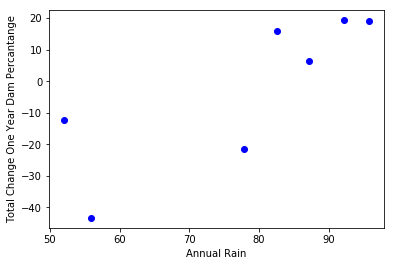

In [547]:
plt.scatter(cdf.TotalAnnualRain, cdf.TotalChangeOneYear,  color='blue')
plt.xlabel("Annual Rain")
plt.ylabel("Total Change One Year Dam Percantange")
plt.show()

While the annual rainfall should be proportional to the dam percentage, some irregularities strike us. Of course, the reasons for this may be the water pumped from the surrounding provinces, low consumption or the factors that we cannot control.

**It would be best to build this algorithm on the city's net water balance for 1 year and the percentage change in the 1-year dams.**

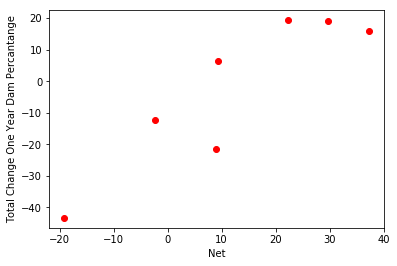

In [549]:
plt.scatter(cdf.Net, cdf.TotalChangeOneYear,  color='red')
plt.xlabel("Net")
plt.ylabel("Total Change One Year Dam Percantange")
plt.show()

There are two main problems with the chart.

* The first is an outlier in 2016(Net+10): A mistake in the official figures may be due to malfunctions, losses or factors that we cannot calculate. So I'm going to take out 2016 while I'm designing artificial intelligence.

* The second important problem is the slowdown in dam occupancy rates when the net water inflow to the city exceeds 30. This again can be related to various problems. Maybe it's an annual thing.

* But the most logical theory that comes to mind may be that more water ingress than the dams of the city can store makes no sense. Yes, water is coming, but it cannot be stored. Of course, there may be unfamiliar factors and errors in my measurement. However, this is not a big outlier. The net water inflow has rarely exceeded 30 in the last 20 years. It does not prevent our algorithm working.

*Cleaning outlier:*

*Let's get 2016 out of the data.Then lets create a new dataframe that contains the two parameters with which I found directly correlate.*

In [551]:
ndf = cdf.drop([2])
zdf = ndf[['Net','TotalChangeOneYear']]
zdf.head(9)

,Net,TotalChangeOneYear
0,37.23,15.80
1,9.31,6.36
3,22.23,19.32
4,29.62,19.12
5,-19.11,-43.32
6,-2.34,-12.27


#### **B.5. Use Of `Supervised Neural Network Models` - `Multi-layer Perceptron` For Predictions**

I will be honest. I had a hard time finding the algorithm that could most accurately cover and predict the relevant data.

It was obvious that Linear-Regression was not going to work. Because when there are more than 30 net water inflows, our dam percentage does not increase proportionally. There are also deviations in the data.

I tried logorithmic and sigmoid functions in non-linear regression. However, when the net water intake was negative, none of them could provide the arithmetic decrease.

Then I used Multi-layer Perceptron, a simple neural network application. I have tried various test - train ratios. This algorithm provided the most accurate results.

*Don't worry, I'll prove it with a graph.*

In [574]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor #I Love This Regressor. MLP
from sklearn.datasets import make_regression


X = zdf.iloc[:, 0:1] #Select Column 1
y = zdf.iloc[:, 1] #Select Column 2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) #Good rate for prevent overfitting.

X=X.astype('int')
y=y.astype('int')


clf = MLPRegressor(hidden_layer_sizes=(10000,100) , max_iter=10000, early_stopping=False) #I found the best settings with a little tweaking
clf.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10000, 100), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [575]:
test = zdf[['Net']]
netdf = pd.DataFrame(test, columns=['Net'])

predictions = clf.predict(test)
df2 = pd.DataFrame(predictions, columns=['Predicte'])


netdf.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

result = pd.concat([netdf, df2],  axis=1)
print(result)


     Net   Predicte
0 -19.11 -43.320514
1  -2.34 -12.247233
2   9.31   6.397171
3  22.23  14.493680
4  29.62  19.105227
5  37.23  23.854976


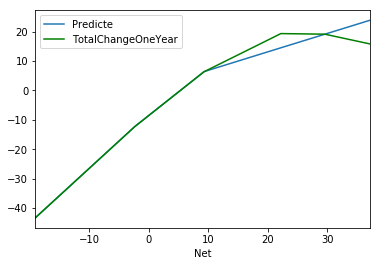

In [576]:
result = result.sort_values(by=['Net'])
zdf = zdf.sort_values(by=['Net'])
ax = plt.gca()

result.plot(kind='line',x='Net',y='Predicte',ax=ax)
zdf.plot(kind='line',x='Net',y='TotalChangeOneYear',color='green', ax=ax)

In this `graph`, We can see that 2 data were taken for the test of the algorithm. However, we can still see that he made very small estimates `with ~ 5 errors` for those values. If he had taken the last data for education, it would decrease the percentage change as the amount of water increased. This is like an impossible thing in real life. Yes, the dams can reach the saturation point, but they do not fall to negative just because there is too much rain. So this version of the Algorithm is pretty good. Anyway, a total net water inflow of 30 - 40 above is not possible under these conditions.

When the `Net Water balance drops to negative`, the algorithm gives `excellent results` even with 3 training sets. We can say that he is an expert estimator about the rate of `water decrease`. So let's use this model to `predict the water problem of Istanbul`.

In [584]:
NowDam = 21.66 #Total Occupancy Rate of Istanbul Dams as of -21.12.2020- Source:Istanbul Buyuksehir Municipality

print("Occupancy rate of Istanbul dams as of 21.12.2020: " + str(NowDam))
print("If our net water balance is 0 next year, our Dam occupancy rate on 21.12.2021: " + str(NowDam + clf.predict([[0]])) ) #NetWater Not Ise
print("If the next year will pass exactly like this year , our Dam occupancy rate on 21.12.2021: " +str(NowDam + clf.predict([[-2.34]])) ) #NetWater Bu yilki Kadar Gelgit Dengemiz Olursa
print("If we can achieve water balance as in 2014, the rainiest time of the last 6 years, our Dam occupancy rate on 21.12.2021: " + str(NowDam + clf.predict([[38]])) ) #NetWater Eger Son 5 Yilin En iyi Yagis Istatistigini 2021de Yakalarsak
print("If we can achieve water balance as in 2010, the rainiest time of the last 10 years, our Dam occupancy rate as of 21.12.2021: " + str(NowDam + clf.predict([[48]])) ) #NetWater Son 10 Yilin en Yagisi Saglanirsa
print("If so much water consumption and low rainfall like in 2019  `the worst water balance of the last 10 years`,  our Dam occupancy rates as of 21.20.2021: " + str(NowDam + clf.predict([[-19]])) ) #NetWater Eger 2019 Yilindaki gibi bir sonraki yilda cok eksiye duserse

print("If the next year will pass exactly like this year , but if everyone saves 10% water, our Dam occupancy rate on 21.12.2021: " +str(NowDam + clf.predict([[7.88]])) ) # 102.90*9/10 = 92.61  ---  102.9-92.61= 10.20 --- -2.32+10.20 = 7.88

Occupancy rate of Istanbul dams as of 21.12.2020: 21.66
If our net water balance is 0 next year, our Dam occupancy rate on 21.12.2021: [14.27300521]
If the next year will pass exactly like this year , our Dam occupancy rate on 21.12.2021: [9.41276697]
If we can achieve water balance as in 2014, the rainiest time of the last 6 years, our Dam occupancy rate on 21.12.2021: [45.99567619]
If we can achieve water balance as in 2010, the rainiest time of the last 10 years, our Dam occupancy rate as of 21.12.2021: [52.240123]
If so much water consumption and low rainfall like in 2019  `the worst water balance of the last 10 years`,  our Dam occupancy rates as of 21.20.2021: [-21.45358778]
If the next year will pass exactly like this year , but if everyone saves 10% water, our Dam occupancy rate on 21.12.2021: [27.10021104]


## **D. Discussion**
----
At the beginning of my study, I checked with the foursquare api the dam coordinates. The results were pretty accurate. Only one dam was marked as "Campground" instead of "Lake". Then I visualized the related water resources on the map.

In the second part of my study, I established a link between the annual amount of net water entering the city and the annual dam occupancy rate change. Classical regression was somewhat inadequate in this regard. Because dams have a saturation point. However, I found very close results in test data with MLP.

However, this is a project prepared in a short time. For example, water leaks in a municipality can deviate 20% of the total water use. Let's even think a little deeper. How many days are sunny in a year can affect the amount of evaporation. Undoubtedly, this will affect the annual percentage change.

In addition, the majority of water use is made by agricultural lands. (Approximately 50 percent of water consumption in Istanbul). In this case, other factors such as the water need of the planted plants, soil yield, number of snowy days may affect the net water balance.

However, I still managed to forecast on an annual basis with the city's net water balance.

Maybe we cannot affect the annual rainfall directly. However, water consumption may affect the net water balance shifting to a large positive.

In the last part of the study, I made a presentation to raise public awareness. Let's say there is as much rain in 2021 as in 2020 and water intake from the surrounding provinces. However, everybody use their water 10% sparingly throughout 2021. In this case, the total water consumption will decrease by 1/10. This leads to an increase of 10.20 in the net water balance. In 2020, the net water balance was -2.34. With 10% reduced water consumption our net water balance for 2021 would be +7.88. In this case, we will see that our dams are  27% in 21.12.2021 . Who wouldn't want their dams to be full!

## **F. Conclusion**
----

As a result, data science helps us at many points in everyday life. For example, even visualizing the dam data we collect from the internet can make people aware that "my water comes from here, they are not too big, I should have been careful".

In addition, according to the estimates we have calculated with MLP, the occupancy rate of our dams can increase by 13% if each person consumes 10% less water, while remaining the same. For exactly this reason, we must use our water very carefully. It is wrong to say that nothing will happen with my consumption. Algorithms have proven this.

Global warming and climate change forces us to use our water resources more rationally. Detailed usage details can be obtained with data science projects. Even, the leak water in the city can be detected and where dam investments can be evaluated.

## **G. References:**

* [1] [Istanbul - Britannica](https://www.britannica.com/place/Istanbul)
* [2] [Istanbul Water Department Official Site](https://www.iski.istanbul/web)
* [3] [Forsquare API](https://developer.foursquare.com/)
* [4] [Istanbul Dam Occupancy Rates](https://data.ibb.gov.tr/en/)
* [5] [Google Map](https://www.google.com/maps/)
* [6] [Falling Water Level In Istanbul Dams Increases Risk Of Disease](https://www.hurriyetdailynews.com/falling-water-level-in-istanbul-dams-increases-risk-of-disease-159762)


